# CS4487 Project: Image classification

## Regarding course project
* External training data is not allowed. Learning can only be performed on the 50,000 training images in **CIFAR10**
* The [**CIFAR10** dataset](https://www.cs.toronto.edu/~kriz/cifar.html) was comprised of 60,000 32 × 32 color photographs of objects from 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.
* Submit the results at [Kaggle CS4487 Course Project](https://www.kaggle.com/c/cs4487cp/)
* The second test set containing roughly 2,000 images (refer to test_data/y_test.npy)

## Evaluation Criteria 

* ### Classification Accuaracy:
  ### $$ Acc(f, D) = \frac{1}{m}\sum_{i=1}^{m}\mathbb{I}[y^i = f(x^i)]$$

* ### File Format:
Upload a file in CSV format, such as:

|         **Index**         |         **Category**        |
|---------------------------|-----------------------------|
| 0                         | 8                           |
| 1                         | 4                           |
| 2                         | 6                           |
| 3                         | 1                           |
| ......                    | ......                      |
| 11999                     | 2                           |

PyTorch Tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

---
## Table of content (for quick jump)
* ### [Import Library](#Import-Library)
* ### [Data Preparation](#Data-Preparation)
* ### [Common Functions](#Common-Functions)
  * #### [Training Function](#Training-function)
  * #### [Testing Function](#Testing-function)
  * #### [Test for each category](#Test-for-each-category)
  * #### [Save Model](#Save-Model)
  * #### [Print Time](#Print-Time)
  * #### [Progress Bar](#Progress-Bar)
* ### [Dual Path Networks](#Dual-Path-Networks)
  * #### [Training](#Train-DPN)
  * #### [Testing](#Test-DPN)
* ### [Run the model in project test data](#Run-the-model-in-project-test-data)
---
---

## Import Library

In [1]:
%pip install progressbar2

Note: you may need to restart the kernel to use updated packages.


In [19]:
import numpy as np
from numpy import *
import cv2
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib
import time
from _datetime import datetime
import pytz

import torch
import torchvision
from torch.utils import data
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

import torch.optim as optim

from progressbar import *
from sys import platform

import matplotlib.pyplot as plt

In [ ]:
if platform == "win32":
    gd_root = "."  # For loacal run
    
else:  # run on Colab
    from google.colab import drive
    drive.mount('/content/gdrive')
    gd_root = "gdrive/My Drive/Colab Notebooks/CS4487/Project"

gd_root

In [3]:
gd_root = "."  # For loacal run

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

basic_path = "basic_cifar_net.pth"
PATH_DPN = "DPN_cifar.pth"

cuda


---
---
## Data Preparation

### Read CIFAR10 data
* The archive contains the files data_batch_1, data_batch_2, ..., data_batch_5, as well as test_batch. Each of these files is a Python "pickled" object produced with cPickle.
* Loaded in this way, each of the batch files contains a dictionary with the following elements:
  * **data**: 
    * a 10,000 x 3,072 numpy array of uint8s. Each row of the array stores a 32 x 32 colour image. 
    * The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. 
    * The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
  * **labels**: 
    * a list of 10,000 numbers in the range 0 - 9. 
    * The number at index i indicates the label of the ith image in the array data.
* The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:
  * **label_names** -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. 
  * For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.

### Loading and normalizing CIFAR10 to dataloader

In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [6]:
trainset = torchvision.datasets.CIFAR10(root=f'{gd_root}/data', train=True, download=False, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size=64, 
                                           shuffle=True, 
                                           num_workers=8, 
                                           pin_memory=True
                                          )

testset = torchvision.datasets.CIFAR10(root=f'{gd_root}/data', train=False, download=False, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, 
                                          batch_size=32,
                                          shuffle=False, 
                                          num_workers=8,
                                          pin_memory=True
                                         )

In [7]:
train_size = len(trainset)
train_size
test_size = len(testset)
test_size
train_batch_len = len(train_loader)
train_batch_len
test_batch_len = len(test_loader)
test_batch_len

50000

10000

782

313

In [8]:
category_dict = {
    'airplane': 1, 
    'automobile': 2, 
    'bird': 3, 
    'cat': 4, 
    'deer': 5, 
    'dog': 6, 
    'frog': 7, 
    'horse': 8, 
    'ship': 9, 
    'truck': 10
}

---
---
## Common Functions

### Mixup 
From [Facebook AI Research](https://github.com/facebookresearch/mixup-cifar10/blob/master/README.md)

In [9]:
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if device == 'cuda':
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

### Training function

In [45]:
train_correct_rate = []
train_loss = []

In [63]:
def training(epoch_num: int, model_name: str, net):

#     print_time_and_msg(f"Preparing data for {epoch_num} epoches")
    
    final_loss = 0.0
    
    correct = 0
    total = 0
    
    train_bar = progress_bar(train_batch_len)
    
    for epoch in range(epoch_num):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader, 0):
                        
            if device == 'cuda':
                inputs, targets = inputs.cuda(), targets.cuda()
            
            # Mixup
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, 1.0)
            
            outputs = net(inputs)
            
            # forward + backward + optimize
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # print statistics
            running_loss += loss.item()
            final_loss = round(running_loss / train_batch_len, 3)
        
        print()
        correct_rate = correct / total
        if epoch == 0:
            save_model(model_name, net)
        elif correct_rate > train_correct_rate[-1]:
            save_model(model_name, net)
        else:
            pass
        
        train_bar.update(epoch)
        
        print_time_and_msg(f"Trained Epoch {epoch + 1}. loss: {final_loss}. Correct rate: {correct_rate}")
        train_correct_rate.append(correct_rate)
        train_loss.append(final_loss)
            
    print_time_and_msg(f'Finished training total {train_size} data for {epoch_num} epoches,\nthe final loss is {final_loss}')


### Testing function

In [13]:
def testing(net):
    test_bar = progress_bar(test_batch_len)
    correct = 0
    total = 0
    
    with torch.no_grad():
        for ti, (inputs, targets) in enumerate(test_loader):
            
            if device == 'cuda':
                inputs, targets = inputs.cuda(), targets.cuda()
                
            loss = criterion(outputs, targets)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            test_bar.update(ti)
    print()
    print(f'Accuracy of the network on the {len(test_loader)} test images: {100 * correct / total}%')



### Test for each category

In [14]:
def test_for_each(net):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for (inputs, targets) in test_loader:
            
            if device == 'cuda':
                inputs, targets = inputs.cuda(), targets.cuda()
                
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == targets).squeeze()
            for i in range(4):
                label = targets[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    print()
    for i in range(10):
        print(f'Accuracy of {list(category_dict)[i]} : {round(100 * class_correct[i] / class_total[i], 2)}%')

### Save Model

In [15]:
def save_model(model_name: str, net):
    PATH_basic = f'{gd_root}/models/{model_name}'
    torch.save(net.state_dict(), PATH_basic)
    print_time_and_msg(f"Saved model")

### Print Time

In [49]:
def print_time_and_msg(msg: str) -> str:
    now_time = time.time()
    readable_time = datetime.fromtimestamp(now_time, pytz.timezone('Asia/Shanghai')).strftime(f'[%H:%M:%S] - {msg}')
    print(readable_time, end="\r")

### Progress Bar

In [32]:
def progress_bar(max_val: int):
    bar = ProgressBar(
        widgets=[
            'Progress: ',
            Percentage(), ' ', 
            Bar('#'), ' ', 
            Timer(), ' ', 
            ETA(), ' '
        ], 
        max_value=max_val
    )
    return bar


### Plot

In [65]:
def plot_train_info(data: list):
    x = [i for i in range(len(data))]
    y = data
    plt.plot(x, y)
#     plt.title(title)
    plt.xticks(np.arange(min(x), max(x)+1, 1))

### Unpickle CIFAR data

In [33]:
def unpickle_cifar10(file: str) -> dict:
    full_name = f"{gd_root}/data/cifar-10-batches-py/{file}"
    
    with open(full_name, 'rb') as fi:
        cifar10_dict = pickle.load(fi, encoding='bytes')
    return cifar10_dict

cifar_meta = unpickle_cifar10("batches.meta")
cifar_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

## Dual Path Networks

### Define DPN

In [34]:
class Bottleneck(nn.Module):
    def __init__(self, last_planes, in_planes, out_planes, dense_depth, stride, first_layer):
        super(Bottleneck, self).__init__()
        self.out_planes = out_planes
        self.dense_depth = dense_depth

        self.conv1 = nn.Conv2d(last_planes, in_planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=32, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        self.conv3 = nn.Conv2d(in_planes, out_planes + dense_depth, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes+dense_depth)

        self.shortcut = nn.Sequential()
        if first_layer:
            self.shortcut = nn.Sequential(
                nn.Conv2d(last_planes, out_planes + dense_depth, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes + dense_depth)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        x = self.shortcut(x)
        d = self.out_planes
        out = torch.cat([x[:,:d,:,:] + out[:,:d,:,:], x[:,d:,:,:], out[:,d:,:,:]], 1)
        out = F.relu(out)
        return out


In [35]:
class DPN(nn.Module):
    def __init__(self, cfg):
        super(DPN, self).__init__()
        in_planes, out_planes = cfg['in_planes'], cfg['out_planes']
        num_blocks, dense_depth = cfg['num_blocks'], cfg['dense_depth']

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.last_planes = 64
        self.layer1 = self._make_layer(in_planes[0], out_planes[0], num_blocks[0], dense_depth[0], stride=1)
        self.layer2 = self._make_layer(in_planes[1], out_planes[1], num_blocks[1], dense_depth[1], stride=2)
        self.layer3 = self._make_layer(in_planes[2], out_planes[2], num_blocks[2], dense_depth[2], stride=2)
        self.layer4 = self._make_layer(in_planes[3], out_planes[3], num_blocks[3], dense_depth[3], stride=2)
        self.linear = nn.Linear(out_planes[3] + (num_blocks[3] + 1) * dense_depth[3], 10)

    def _make_layer(self, in_planes, out_planes, num_blocks, dense_depth, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for i,stride in enumerate(strides):
            layers.append(Bottleneck(self.last_planes, in_planes, out_planes, dense_depth, stride, i==0))
            self.last_planes = out_planes + (i + 2) * dense_depth
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [36]:
def DPN26():
    cfg = {
        'in_planes': (96,192,384,768),
        'out_planes': (256,512,1024,2048),
        'num_blocks': (2,2,2,2),
        'dense_depth': (16,32,24,128)
    }
    return DPN(cfg)

def DPN92():
    cfg = {
        'in_planes': (96,192,384,768),
        'out_planes': (256,512,1024,2048),
        'num_blocks': (3,4,20,3),
        'dense_depth': (16,32,24,128)
    }
    return DPN(cfg)

### Train DPN

In [37]:
DPN_net = DPN92()
DPN_net.to(device)
if device == 'cuda':
    DPN_net = torch.nn.DataParallel(DPN_net)
    cudnn.benchmark = True

DPN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(96, 272, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 272, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(DPN_net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

#### Go to [training function](#Training-function)

In [73]:
model_PATH = f"{gd_root}/models/{PATH_DPN}"
DPN_net.load_state_dict(torch.load(model_PATH))
print_time_and_msg(f"Loaded model: {PATH_DPN}")

<All keys matched successfully>

In [74]:
epoches = 500

In [ ]:
print_time_and_msg(f"Start training for {epoches} epoches\n")
training(epoch_num=epoches, model_name=PATH_DPN, net=DPN_net)

Progress: N/A% |                        | Elapsed Time: 0:00:00 ETA:  --:--:-- 

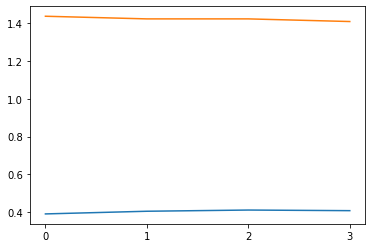

In [66]:
plot_train_info(train_correct_rate)
plot_train_info(train_loss)

### Test DPN

In [24]:
model_PATH = f"{gd_root}/models/{PATH_DPN}"
test_net = DPN92()
if device == 'cuda':
    test_net = torch.nn.DataParallel(test_net)
    cudnn.benchmark = True
test_net.load_state_dict(torch.load(model_PATH))

<All keys matched successfully>

In [ ]:
testing(test_net)

In [ ]:
test_for_each(test_net)

---
---
## Run the model in project test data 

### Load test data

In [39]:
project_testset = np.load(f"{gd_root}/data/test_data/y_test.npy").astype(np.uint8)
project_testset = np.moveaxis(project_testset, -1, 2)
project_testset = np.moveaxis(project_testset, 2, 1)
project_testset.shape
type(project_testset)

(12000, 3, 32, 32)

numpy.ndarray

### Convert to DataLoader ([Convertion Reference](https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader))

In [40]:
from torch.utils import data
tensor_testset = torch.Tensor(project_testset)
the_dataset = data.TensorDataset(tensor_testset)
project_test_loader = data.DataLoader(the_dataset, 
                                      batch_size=32,
                                      num_workers=8,
                                      pin_memory=True
                                     )
test_batch_len = len(project_test_loader)

### Run the test

In [41]:
predict_result = []

In [42]:
def run_project_test(net, model_path):
    net.load_state_dict(torch.load(model_path))
    
    test_pbar = progress_bar(test_batch_len)
    
    with torch.no_grad():
        for index, imgs in enumerate(project_test_loader):
            
            imgs = torch.stack([torch.Tensor(i) for i in imgs]).squeeze()
            
            if device == 'cuda':
                imgs.cuda()
                
            outputs = net(imgs)
            _, predicted = torch.max(outputs.data, 1)
            
            for p in predicted:
                predict_result.append(p)
            
            test_pbar.update(index)
      
    print(len(predict_result))

In [43]:
model_PATH = f"{gd_root}/models/{PATH_DPN}"
p_test_net = DPN92()
if device == 'cuda':
    p_test_net.to(device)
    p_test_net = torch.nn.DataParallel(p_test_net)
    cudnn.benchmark = True
run_project_test(p_test_net, model_PATH)

DPN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(96, 272, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 272, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(

Progress:  99% |####################### | Elapsed Time: 0:00:18 ETA:   0:00:00 

12000


In [44]:
len(predict_result)

12000

### Save to csv file

In [45]:
def save_to_csv(result: list):
    result_df = pd.DataFrame(
        list(predict_result),
        columns=["Category"]
    )
    result_df.index.name = "Index"
    # result_df
    result_df.to_csv(f"{gd_root}/predict_result.csv")

In [46]:
save_to_csv(predict_result)